# Chroma from Luma (CfL)

In [60]:
%matplotlib inline

import os
import tarfile

from multiprocessing import Pool

import numpy as np

import matplotlib.pyplot as plt

from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.cluster.vq import kmeans2
from scipy.cluster.vq import kmeans
from scipy.ndimage  import imread
from scipy.misc  import imsave

class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)
    
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.

    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.

    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.

    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])

    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = np.int(n / arrays[0].size)
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in range(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [58]:
img_folder = "images/kodim/"
kodims = []
kodim_files = []
for file in sorted(os.listdir(img_folder)):
    if file.endswith(".png"):
        kodim_files.append(file)
        kodims.append(imread(os.path.join(img_folder, file), mode="YCbCr"))
num_kodim = len(kodims)
        
def psnr(im1, im2):
    h, w = im1.shape
    sse = np.sum((im1 - im2)**2)
    return 20 * np.log10(255) - 10 * np.log10(sse/(h*w))

In [4]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 $('#toggle').attr('value', 'Show code')  
 } else {
 $('div.input').show();
 $('#toggle').attr('value', 'Hide code') 
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggle" value="Show code"></form>''')

In [5]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [ ]:
block_size = 8

## Introduction

Chroma from Luma (CfL) is a coding tool that predicts information in the chromatic planes based on previously encoded information in the luma plane. The underlying assumption is that a local correlation exists between the luma plane and its chromatic counterparts. This correlation can be seen in the following image, notice the resemblance between the chromatic planes (Cr and Cr) and the luma plane.

Note: _A presentation was made from the work in this notebook, the latest version can be downloaded from_ https://gitlab.com/luctrudeau/CfL-AV1-Presentation/builds/artifacts/master/file/cfl-av1-presentation.pdf?job=build


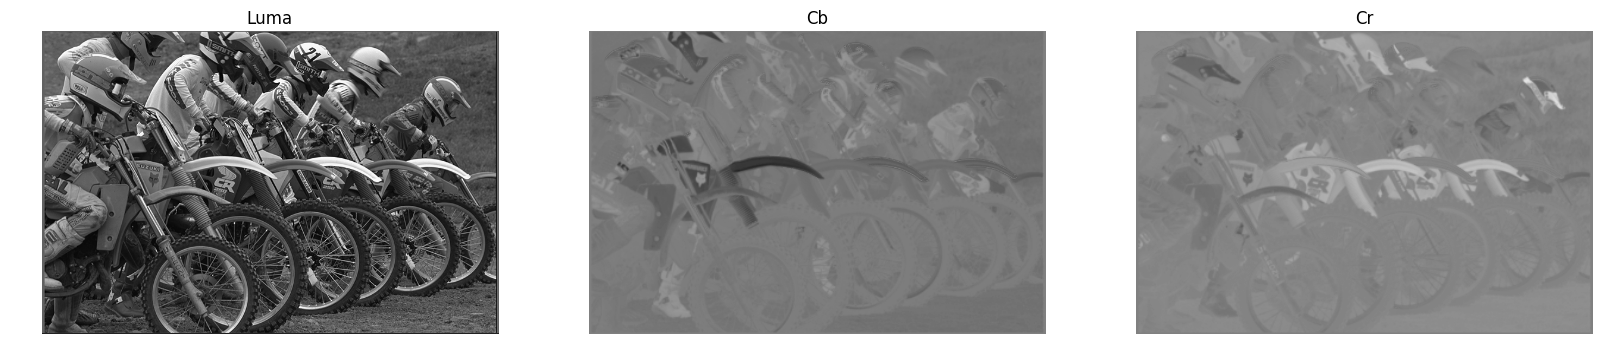

In [6]:
def showPlanes(im):
    plt.figure(figsize=(20,15))
    plt.subplot(1,3,1)
    showImage(im[:,:,0], "Luma")
    plt.subplot(1,3,2)
    showImage(im[:,:,1], "Cb")
    plt.subplot(1,3,3)
    showImage(im[:,:,2], "Cr")

def showImage(im, title):
    plt.imshow(im, cmap = plt.get_cmap('gray'), vmin = 0, vmax = 255)
    plt.axis('off')
    plt.title(title)
    
randIm = kodims[int(np.round(np.random.rand()*len(kodims)))]
showPlanes(randIm);

In this document, we present the proposed CfL approach for the AV1 Codec. This new version of CfL draws from the strengths of the CfL implementation of the Thor codec and the CfL implementation of the Daala codec. 

In [[1]](https://tools.ietf.org/html/draft-midtskogen-netvc-chromapred-02), Midtskogen proposes to compute $\alpha$ and $\beta$ using the predicted values of luma and chroma. These values are available in both the encoder and decoder. As such, they are not signaled in the bitstream. Additionally, Midtskogen uses a threshold of 64 on the mean squared error between the reconstructed luma pixel and the predicted luma pixel to decide whether or not CfL should be used. An important note about the work of Midtskogen is that it applies to intra frame coding and inter frame coding.

In [[2]](https://people.xiph.org/~unlord/spie_cfl.pdf), Egge and Valin propose a frequency domain version of CfL. the authors exploit the gain-shape coding nature of perceptual vector quantization (PVQ) to avoid having to perform model fitting to find $\alpha$ and $\beta$. As such, only a sign bit needs to be signaled. It is important to note that this version of CfL only predicts ACs coefficients.

The proposed solution is similar to [1] in that it is performed in the spatial domain and least squares is used. However, it differs from [1] in that $\alpha$ is signaled in the bitstream. As for $\beta$, Midtskogen computes it using the least squares equation, we propose to use DC_PRED as the value of $\beta$. This aligns with [2], in that CfL does not predict the DC.

The characteristics of the different CfL implementations are described in the following table.

|                                | Thor[1]    | Daala[2]  | Proposed |
|--------------------------------|------------|-----------|----------|
| Prediction Domain              | Spatial    | Frequency | Spatial  |
| Bitstream Signaling            | None       | Sign bit  | Alpha    |
| Encoder model fitting          | Yes        | Via PVQ   | Yes      |
| Decoder model fitting          | Yes        | No        | No       |
| Luma values used for fit       | Predicted  | Luma      | Luma     |
| Chroma values used for fit     | Predicted  | Chroma    | Chroma   |


## CfL Fundamentals

Although it does not always hold, the assumption of a linear relationship between the luma plane and its chromatic counterparts is not far-fetched. For example, the following image shows the relationship between the Luma and Chroma for an $8 \times 8$ block in the previous image.

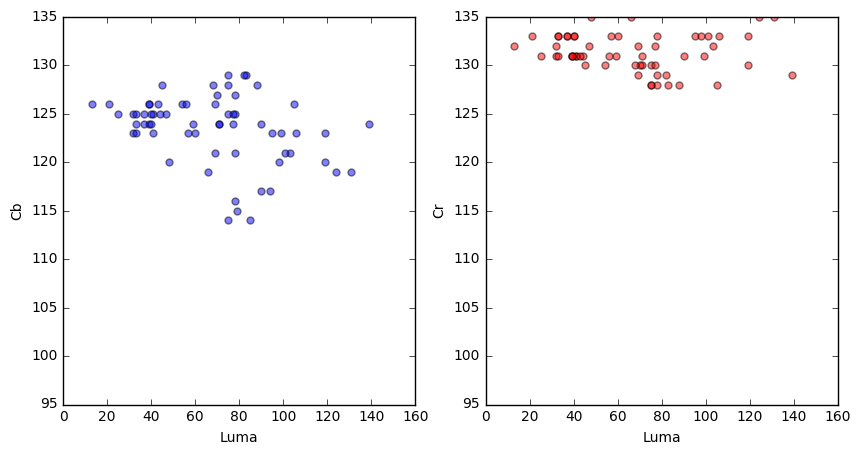

In [7]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(randIm[300:308,500:508,0].ravel(), randIm[300:308,500:508,1].ravel(), c="blue", alpha=0.5, s=25)
plt.xlabel("Luma")
plt.ylabel("Cb")
plt.gca().set_ylim([95, 135])
plt.subplot(1,2,2)
plt.scatter(randIm[300:308,500:508,0].ravel(), randIm[300:308,500:508,2].ravel(), c="red", alpha=0.5, s=25)
plt.xlabel("Luma")
plt.ylabel("Cr")
plt.gca().set_ylim([95, 135]);

Assuming that this relationship also exists between the $i$th reconstructed Luma pixel $\hat{L}_i$ and $i$th Chroma pixel $C_i$, 
a chromatic prediction of $C_i$ can be computed using the following equation

$$C'_i = \alpha \times \hat{L}_i + \beta,$$

where $\alpha$ is the slope and $\beta$ is y intercept. For a block of $N$ pixels, $\alpha$ and $\beta$ are computed with the least squares equations as follows

$$\alpha = \frac{N \sum_i \hat{L}_i C_i - \sum_i \hat{L}_i \sum_i C_i}{N \sum_i L_i^2 - (\sum \hat{L}_i)^2},$$

$$\beta = \frac{\sum_i C_i - \alpha \sum_i \hat{L}_i}{N}.$$

As explained in [1], signaling $\alpha$ and $\beta$ on a per block basis is too expensive. To avoid signaling these parameters, Midtskogen proposes instead to compute $\alpha'$ and $\beta'$ by replacing the actual values $\hat{L}$ and $C$ by their predicted counterparts $L'$ and $C'$.

The advantage of such an approach is that $L'$ and $C'$ are available to both the encoder and decoder, the model fitting is performed during encoding and during decoding, thus signaling alpha and beta is avoided. The disadvantage of this approach is that the model will fit the prediction but not the actual data. In the context of intra coding, the prediction might significantly differ from the actual values. This loss of precision will increase distortion and rate.

Fitting the model on the real values of $\hat{L}$ and $C$ generates a more precise model. However, this information is not available to the decoder and must be signaled in the bitstream. In this proposal, we will present different techniques to reduce the rate required to signal the model fitting parameters.

Let $\bar{L}$ be the subtraction of $\hat{L}$ by its average for a given block. Notice that $\bar{L}$ is zero mean, it follows that

$$\sum_i \bar{L_i} = 0.$$

Notice that when we replace $\hat{L}$ with $\bar{L}$ in the equation of $\beta$, we get the average chromatic pixel value. It just so happens that the intra prediction mode DC_PRED is designed to predict the average pixel value.

Next, let $\bar{C'}$ be the subtraction of $C$ by the predicted average using DC_PRED.

Replacing $\hat{L}$ by $\bar{L}$ and $C$ with $\bar{C'}$ in the equations of $\alpha$ and $\beta$ yields

$$\bar{\alpha} = \frac{\sum_i \bar{L}_i \bar{C'}_i}{\sum_i \bar{L}_i^2},$$

$$\bar{\beta} = \frac{\sum_i \bar{C'}_i}{N}.$$

Notice that $\bar{\beta}$ is the average of the residual of the chromatic block.

Based on the assumption that $\bar{\beta} \approx 0$, we predict chroma as follows

$$ C''_i = \bar{\alpha} \times \bar{L_i} + DC\_PRED $$

_Note that it could also be possible to signal $\sum_i \bar{L_i} \bar{C'_i}$ instead of $\alpha$. However, signaling $\alpha$ give better results._

### Symbolic version of the fundamentals

In this section, we show that the equation for $\bar{\alpha}$ from the previous section is optimal given that the error metric is the sum of squares between the CfL prediction and chroma block and that no $\beta$ is used.

First, let's exand the sum of squares between the CfL prediction and the chroma block

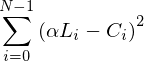

In [8]:
from sympy import diff, symbols, init_printing, solveset, Sum, IndexedBase, Eq, expand, factor
init_printing()

i, a, N = symbols('i, alpha N')
L = IndexedBase('L')
C = IndexedBase('C')

e = Sum((L[i]*a-C[i])**2, (i,0,N-1))
e

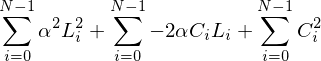

In [9]:
e2 = e.expand()
e2

Next, we take the derivative with respect to x and factorize each term

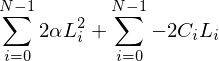

In [12]:
d = diff(e2,a)
d

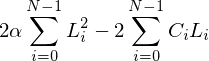

In [14]:
f = factor(Sum(2*a*L[i]**2, (i, 0, N - 1))) + factor(Sum(-2*C[i]*L[i], (i, 0, N - 1)))
f

Finally, to find the extremums, we solve for x, when the previous equation = 0

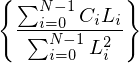

In [16]:
solveset(Eq(f,0),a)

This matches what we obtained for $\bar{\alpha}$ in the previous section. The difference is that, in the previous section we changed $L$ to be zero mean, whereas in this section we removed $\beta$ completely. In both cases, we get the same equation.

In other words, using a zero mean $L$ gives the optimal $\alpha$ given that no $\beta$ is used.

**TODO**: Find a way to take into consideration rounding when SSE is computed (deriving round() is a pain) 

In [52]:
def cfl(im, block_size, plane):
    height, width, z = im.shape
    cfl = np.array(np.zeros((height, width)), dtype='uint8')
    
    for y in range(0, height, block_size):
        for x in range(0, width, block_size):
            bY = im[y:y+block_size, x:x+block_size, 0].astype(int)
            bC = im[y:y+block_size, x:x+block_size, plane].astype(int)
            
            L = bY - np.mean(bY).astype(int)
            C = bC - np.mean(bC).astype(int)
            
            sLL = np.sum(L*L)
            sLC = np.sum(L*C)
            
            if sLL != 0:
                a = sLC / sLL
            else:
                a = 0
            cfl[y:y+block_size, x:x+block_size] = np.round(a * L + np.mean(bC)).astype('uint8')
    return cfl

def cfl_psnr(im):
    psnr_cb = psnr(im[:, :, 1], cfl(im, block_size, 1))
    psnr_cr = psnr(im[:, :, 2], cfl(im, block_size, 2))
    return psnr_cb, psnr_cb

In [111]:
def cfl_prop(im, block_size, plane):
    height, width, z = im.shape
    cfl = np.array(np.zeros((height, width)), dtype='uint8')
    alphas = []
    
    for y in range(0, height, block_size):
        for x in range(0, width, block_size):
            bY = im[y:y+block_size, x:x+block_size, 0].astype(int)
            bC = im[y:y+block_size, x:x+block_size, plane].astype(int)
            
            above_row = im[max(y-1,0), x:x+block_size, plane].astype(int)
            left_col = im[y:y+block_size, max(x-1,0), plane].astype(int)
            DC_PRED = np.mean([above_row, left_col])
            
            L = bY - np.mean(bY)
            C = bC - DC_PRED
            
            sLL = np.sum(L*L)
            sLC = np.sum(L*C)
            
            if sLL != 0:
                alpha = sLC / sLL
            else:
                alpha = 0
            alphas.append(alpha)
            cfl[y:y+block_size, x:x+block_size] = np.round(alpha * L + DC_PRED).astype('uint8')
            
    return cfl, alphas

def cfl_prop_psnr(im):
    cfl_cb, a_cb = cfl_prop(im, block_size, 1)
    psnr_cb = psnr(im[:, :, 1], cfl_cb)
    cfl_cr, a_cr = cfl_prop(im, block_size, 2)
    psnr_cr = psnr(im[:, :, 2], cfl_cr)
    return a_cb, psnr_cb, a_cr, psnr_cr

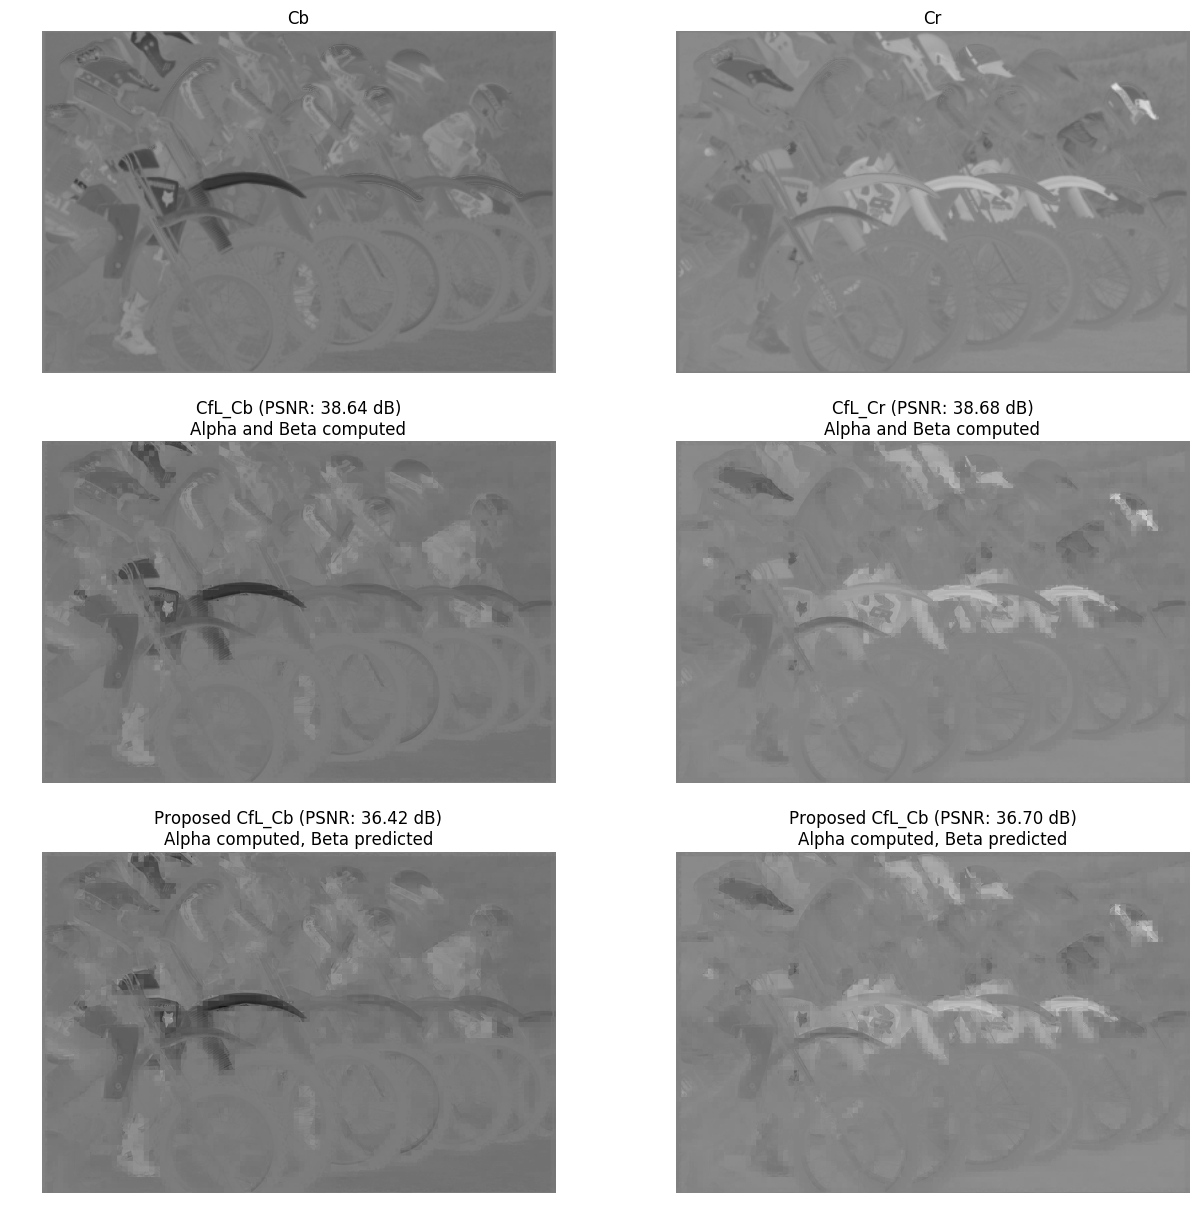

In [112]:
cfl_prob_cb, alphas_cr = cfl_prop(randIm, block_size, 1)
cfl_prob_cr, alphas_cb = cfl_prop(randIm, block_size, 2)

cfl_cb = cfl(randIm, block_size, 1)
cfl_cr = cfl(randIm, block_size, 2)
    
plt.figure(figsize=(15,15))
plt.subplot(3,2,1)
showImage(randIm[:,:,1], "Cb")
plt.subplot(3,2,2)
showImage(randIm[:,:,2], "Cr")
plt.subplot(3,2,3)
showImage(cfl_cb, "CfL_Cb (PSNR: %0.2f dB)\nAlpha and Beta computed" % psnr(randIm[:,:,1], cfl_cb))
plt.subplot(3,2,4)
showImage(cfl_cr, "CfL_Cr (PSNR: %0.2f dB)\nAlpha and Beta computed" % psnr(randIm[:,:,2], cfl_cr))
plt.subplot(3,2,5)
showImage(cfl_prob_cb, "Proposed CfL_Cb (PSNR: %0.2f dB)\nAlpha computed, Beta predicted" % psnr(randIm[:,:,1], cfl_prob_cb))
plt.subplot(3,2,6)
showImage(cfl_prob_cr, "Proposed CfL_Cb (PSNR: %0.2f dB)\nAlpha computed, Beta predicted" % psnr(randIm[:,:,2], cfl_prob_cr))

For a more general overview of the precision of the proposed approach, the following table shows the quality loss of the proposed CfL scheme on the images of the [Kodak Lossless True Color Image Suite](http://r0k.us/graphics/kodak/index.html)

In [113]:
table = ListTable()
table.append(['File name', 'PSNR CfL Cb', 'PSNR CfL Proposed Cb', 'PSNR CfL Cb', 'PSNR CfL Proposed Cr'])

psnr_cfl_cb = np.zeros((24,1))
psnr_cfl_prop_cb = np.zeros((24,1))
psnr_cfl_cr = np.zeros((24,1))
psnr_cfl_prop_cr = np.zeros((24,1))
alphas_cb = np.array([])
alphas_cr = np.array([])

with Pool() as pool:
    results = pool.map(cfl_psnr, kodims)
    results_prop = pool.map(cfl_prop_psnr, kodims)

for k in range(0,num_kodim):
    psnr_cb, psnr_cr = results[k]
    a_cb, psnr_prop_cb, a_cr, psnr_prop_cr = results_prop[k]
    alphas_cb = np.concatenate((alphas_cb, a_cb), axis=0)
    alphas_cr = np.concatenate((alphas_cr, a_cr), axis=0)
    psnr_cfl_cb[k] = round(psnr_cb, 2)
    psnr_cfl_prop_cb[k] = round(psnr_prop_cb, 2)
    psnr_cfl_cr[k] = round(psnr_cr, 2)
    psnr_cfl_prop_cr[k] = round(psnr_prop_cr, 2)
    table.append([kodim_files[k], str(psnr_cfl_cb[k]), str(psnr_cfl_prop_cb[k]), str(psnr_cfl_cr[k]), str(psnr_cfl_prop_cr[k])])

mean_psnr_cfl_prob_cb = round(np.mean(psnr_cfl_prop_cb),2)
mean_psnr_cfl_prob_cr = round(np.mean(psnr_cfl_prop_cr),2)
table.append(['Average', round(np.mean(psnr_cfl_cb),2), mean_psnr_cfl_prob_cb, round(np.mean(psnr_cfl_cr),2), mean_psnr_cfl_prob_cr])
table

File name,PSNR CfL Cb,PSNR CfL Proposed Cb,PSNR CfL Cb,PSNR CfL Proposed Cr
kodim01.png,[ 44.36],[ 42.45],[ 44.36],[ 38.62]
kodim02.png,[ 41.25],[ 39.83],[ 41.25],[ 36.06]
kodim03.png,[ 43.32],[ 40.63],[ 43.32],[ 42.05]
kodim04.png,[ 46.27],[ 43.07],[ 46.27],[ 36.3]
kodim05.png,[ 38.64],[ 36.42],[ 38.64],[ 36.7]
kodim06.png,[ 43.93],[ 40.94],[ 43.93],[ 41.78]
kodim07.png,[ 40.87],[ 38.33],[ 40.87],[ 40.23]
kodim08.png,[ 41.29],[ 38.05],[ 41.29],[ 36.76]
kodim09.png,[ 43.95],[ 41.2],[ 43.95],[ 42.5]
kodim10.png,[ 44.66],[ 41.3],[ 44.66],[ 42.02]


The PSNR reduction indicates the cost associated of assuming that $\bar{\beta} \approx 0$.

## Quantization

As we already mentioned, signaling one $\bar{\alpha}$ for each chromatic plane for every block in a frame is quite expensive. Quantization allows us to reduce signaling cost at the expense of precision. A quantization function will take a value of $\bar{\alpha}$ and produce a value in a subset of the domain of $\bar{\alpha}$. In other words, we are restricting the number of possible $\bar{\alpha}$ values.

The following heatmaps illustrate the range of $\bar{\alpha}$ for each chromatic plane. These values are obtained using the AV1 encoder over Subset1.

In [101]:
def load_alphas(qp):
    alphas = np.empty((0,2), int)
    with tarfile.open(os.path.join('data', 'alphas', "subset1_alphas_%d.tar.xz" % qp)) as tf:
        for entry in tf:
            if entry.isfile():
                alphas = np.append(alphas, np.genfromtxt(tf.extractfile(entry), delimiter=','), axis=0)
    return alphas


alphas_20 = load_alphas(20)
alphas_32 = load_alphas(32)
alphas_43 = load_alphas(43)
alphas_55 = load_alphas(55)
alphas_63 = load_alphas(63)

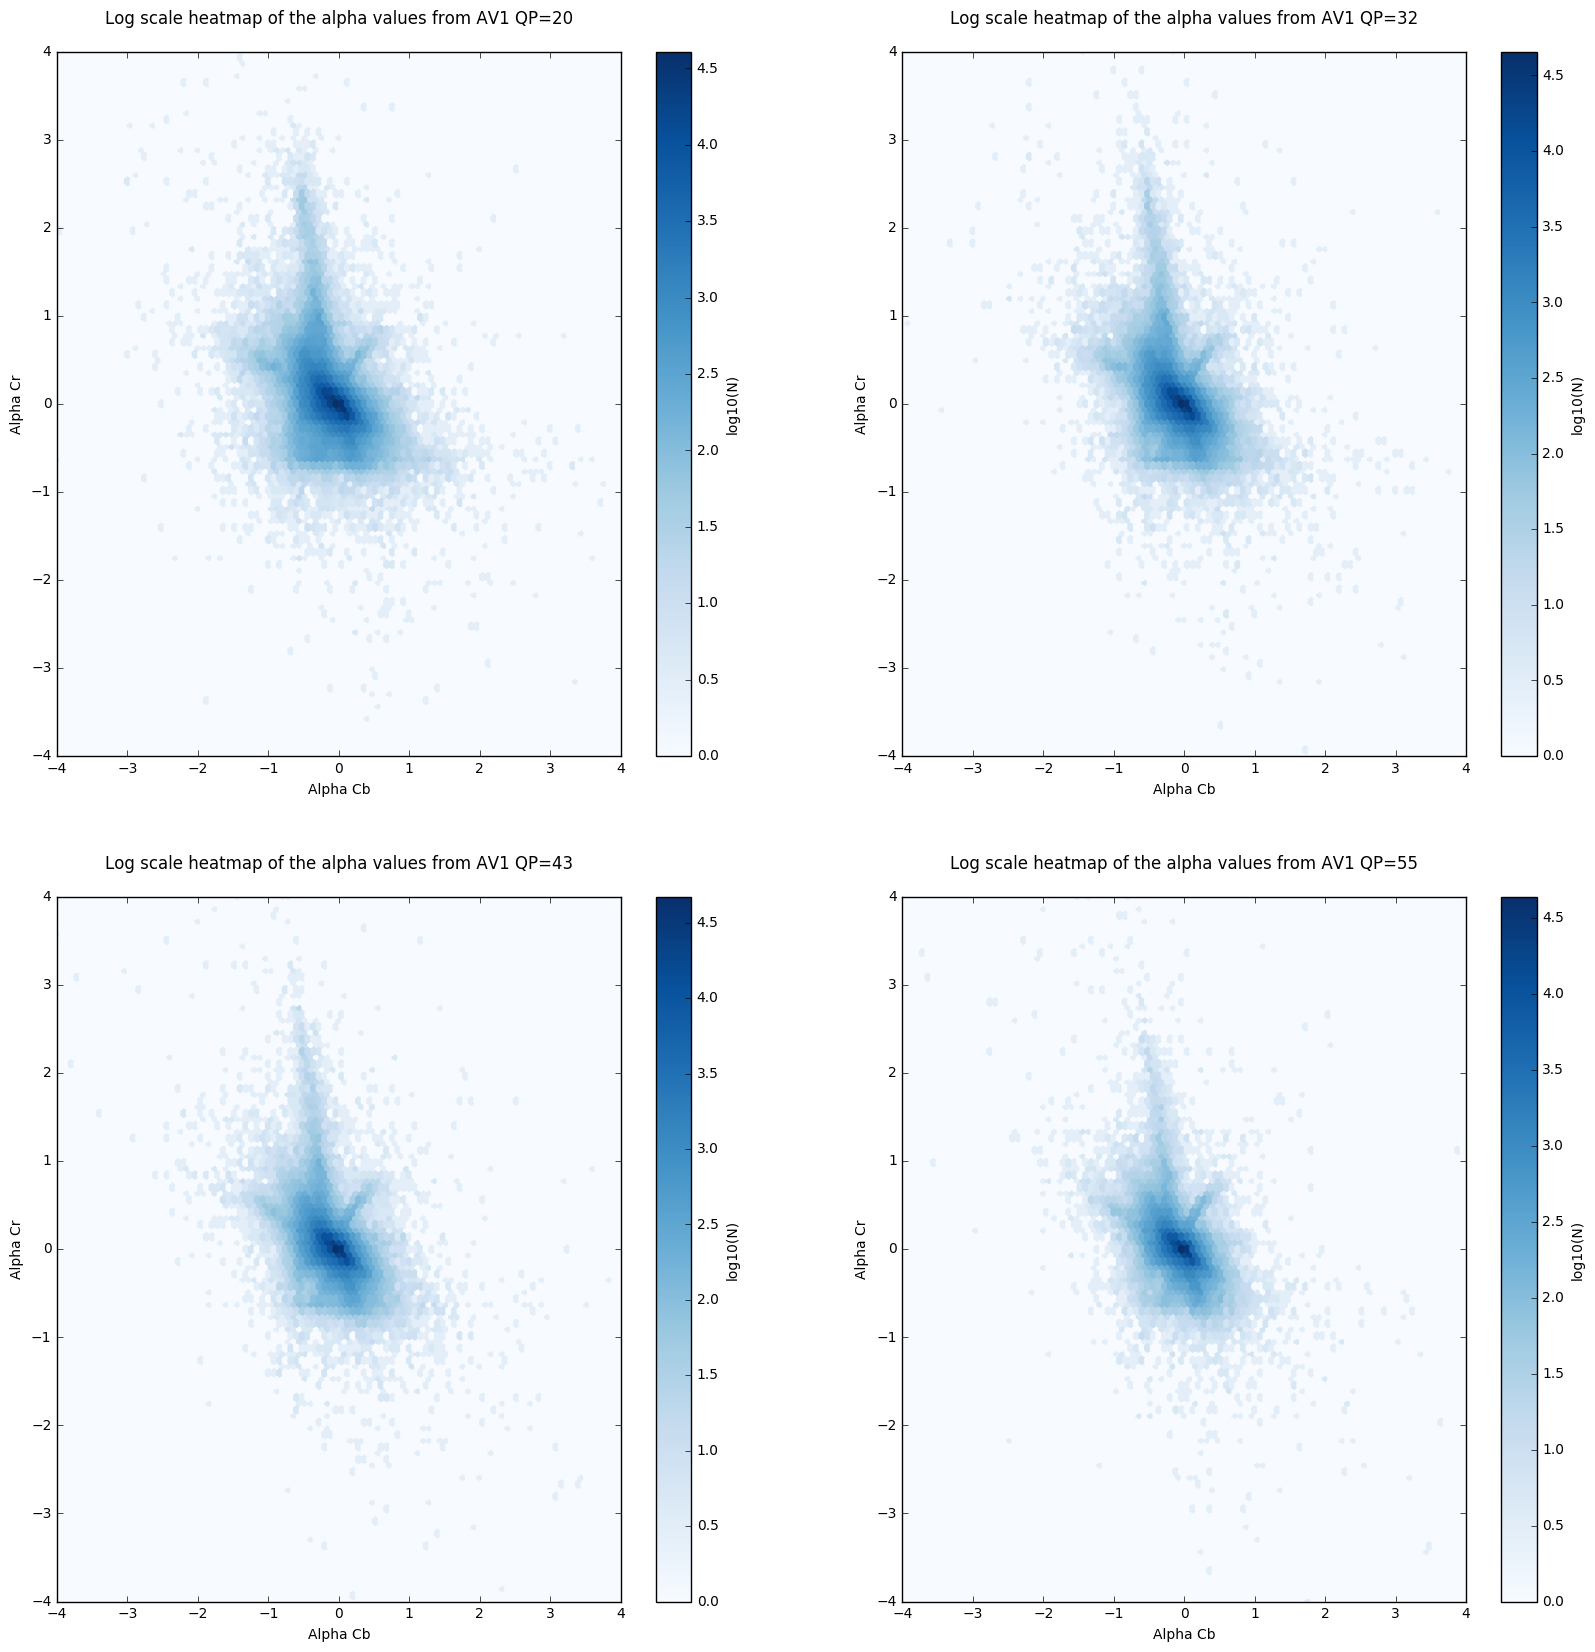

In [102]:
def alpha_heatmap(alphas, title):
    plt.gca().set_xlim([-4, 4])
    plt.gca().set_ylim([-4, 4])
    plt.hexbin(alphas[:,0], alphas[:,1], bins='log', cmap='Blues', extent=[-4, 4, -4, 4])
    cb = plt.colorbar();
    cb.set_label('log10(N)')
    
    plt.xlabel("Alpha Cb")
    plt.ylabel("Alpha Cr")
    plt.title(title);


plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
alpha_heatmap(alphas_20, "Log scale heatmap of the alpha values from AV1 QP=20\n")
plt.subplot(2,2,2)
alpha_heatmap(alphas_32, "Log scale heatmap of the alpha values from AV1 QP=32\n")
plt.subplot(2,2,3)
alpha_heatmap(alphas_43, "Log scale heatmap of the alpha values from AV1 QP=43\n")
plt.subplot(2,2,4)
alpha_heatmap(alphas_55, "Log scale heatmap of the alpha values from AV1 QP=55\n")

The previous heatmaps, show the density of values accross the domain of $\bar{\alpha}$ for both chromatic planes. Since we will signal the quantized alpha value and its sign separately, we consider $\mid\bar{\alpha}\mid$.

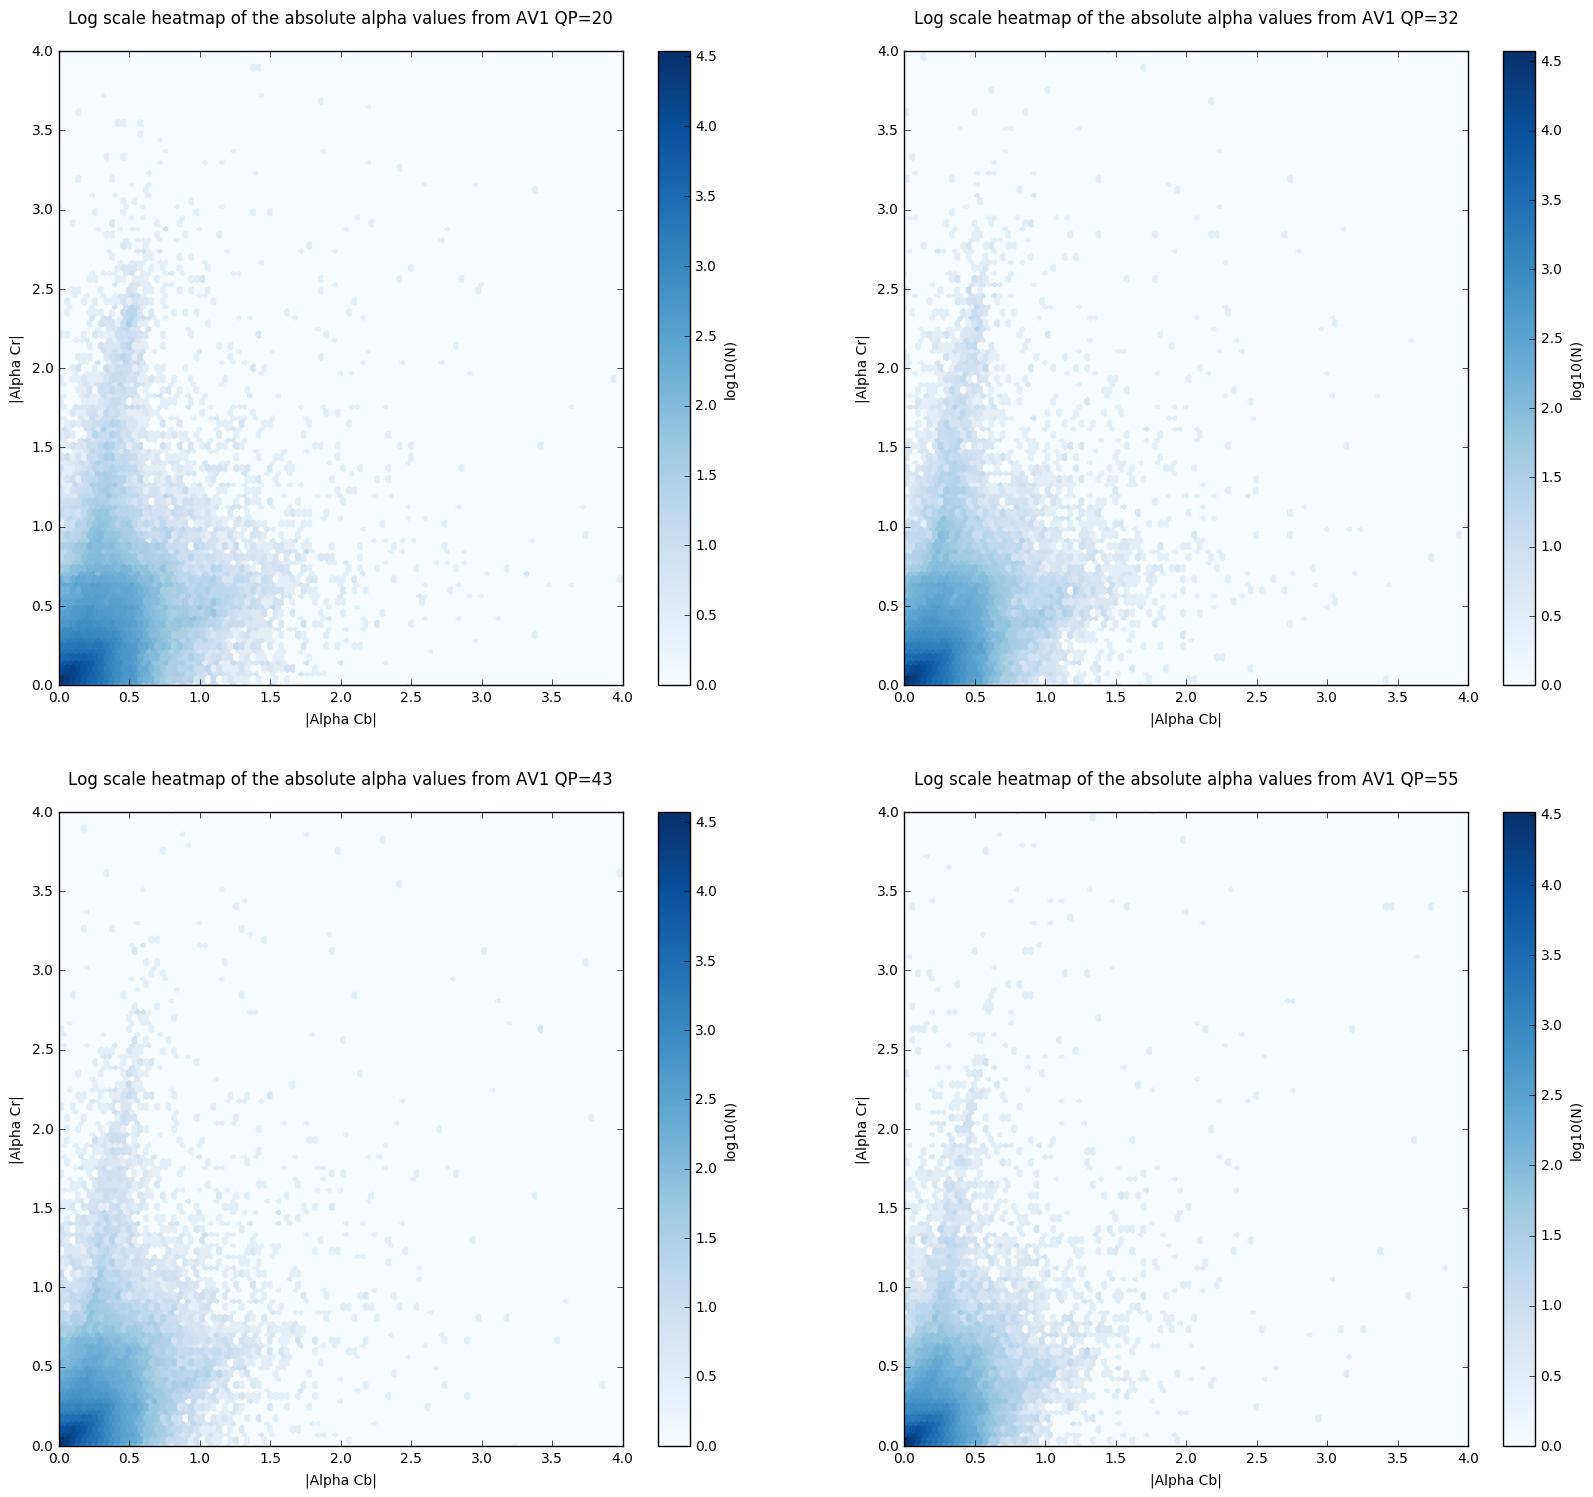

In [103]:
def abs_alpha_heatmap(alphas, title):
    plt.gca().set_xlim([0, 4])
    plt.gca().set_ylim([0, 4])
    plt.hexbin(np.abs(alphas[:,0]), np.abs(alphas[:,1]), bins='log', cmap='Blues', extent=[0, 4, 0, 4])
    cb = plt.colorbar();
    cb.set_label('log10(N)')
    
    plt.xlabel("|Alpha Cb|")
    plt.ylabel("|Alpha Cr|")
    plt.title(title);


plt.figure(figsize=(20,18))
plt.subplot(2,2,1)
abs_alpha_heatmap(alphas_20, "Log scale heatmap of the absolute alpha values from AV1 QP=20\n")
plt.subplot(2,2,2)
abs_alpha_heatmap(alphas_32, "Log scale heatmap of the absolute alpha values from AV1 QP=32\n")
plt.subplot(2,2,3)
abs_alpha_heatmap(alphas_43, "Log scale heatmap of the absolute alpha values from AV1 QP=43\n")
plt.subplot(2,2,4)
abs_alpha_heatmap(alphas_55, "Log scale heatmap of the absolute alpha values from AV1 QP=55\n")

As the heatmaps suggest, a fixed quantization step size is not desired. To obtain a non-uniform quantization table, we resort to the _k_-means clustering.

Using $k$-means, we can find the values of $k$ points that minimizes the error along a given chromatic plane. For example, using $k=4$ for Cb and for Cr. We get the following 16 points

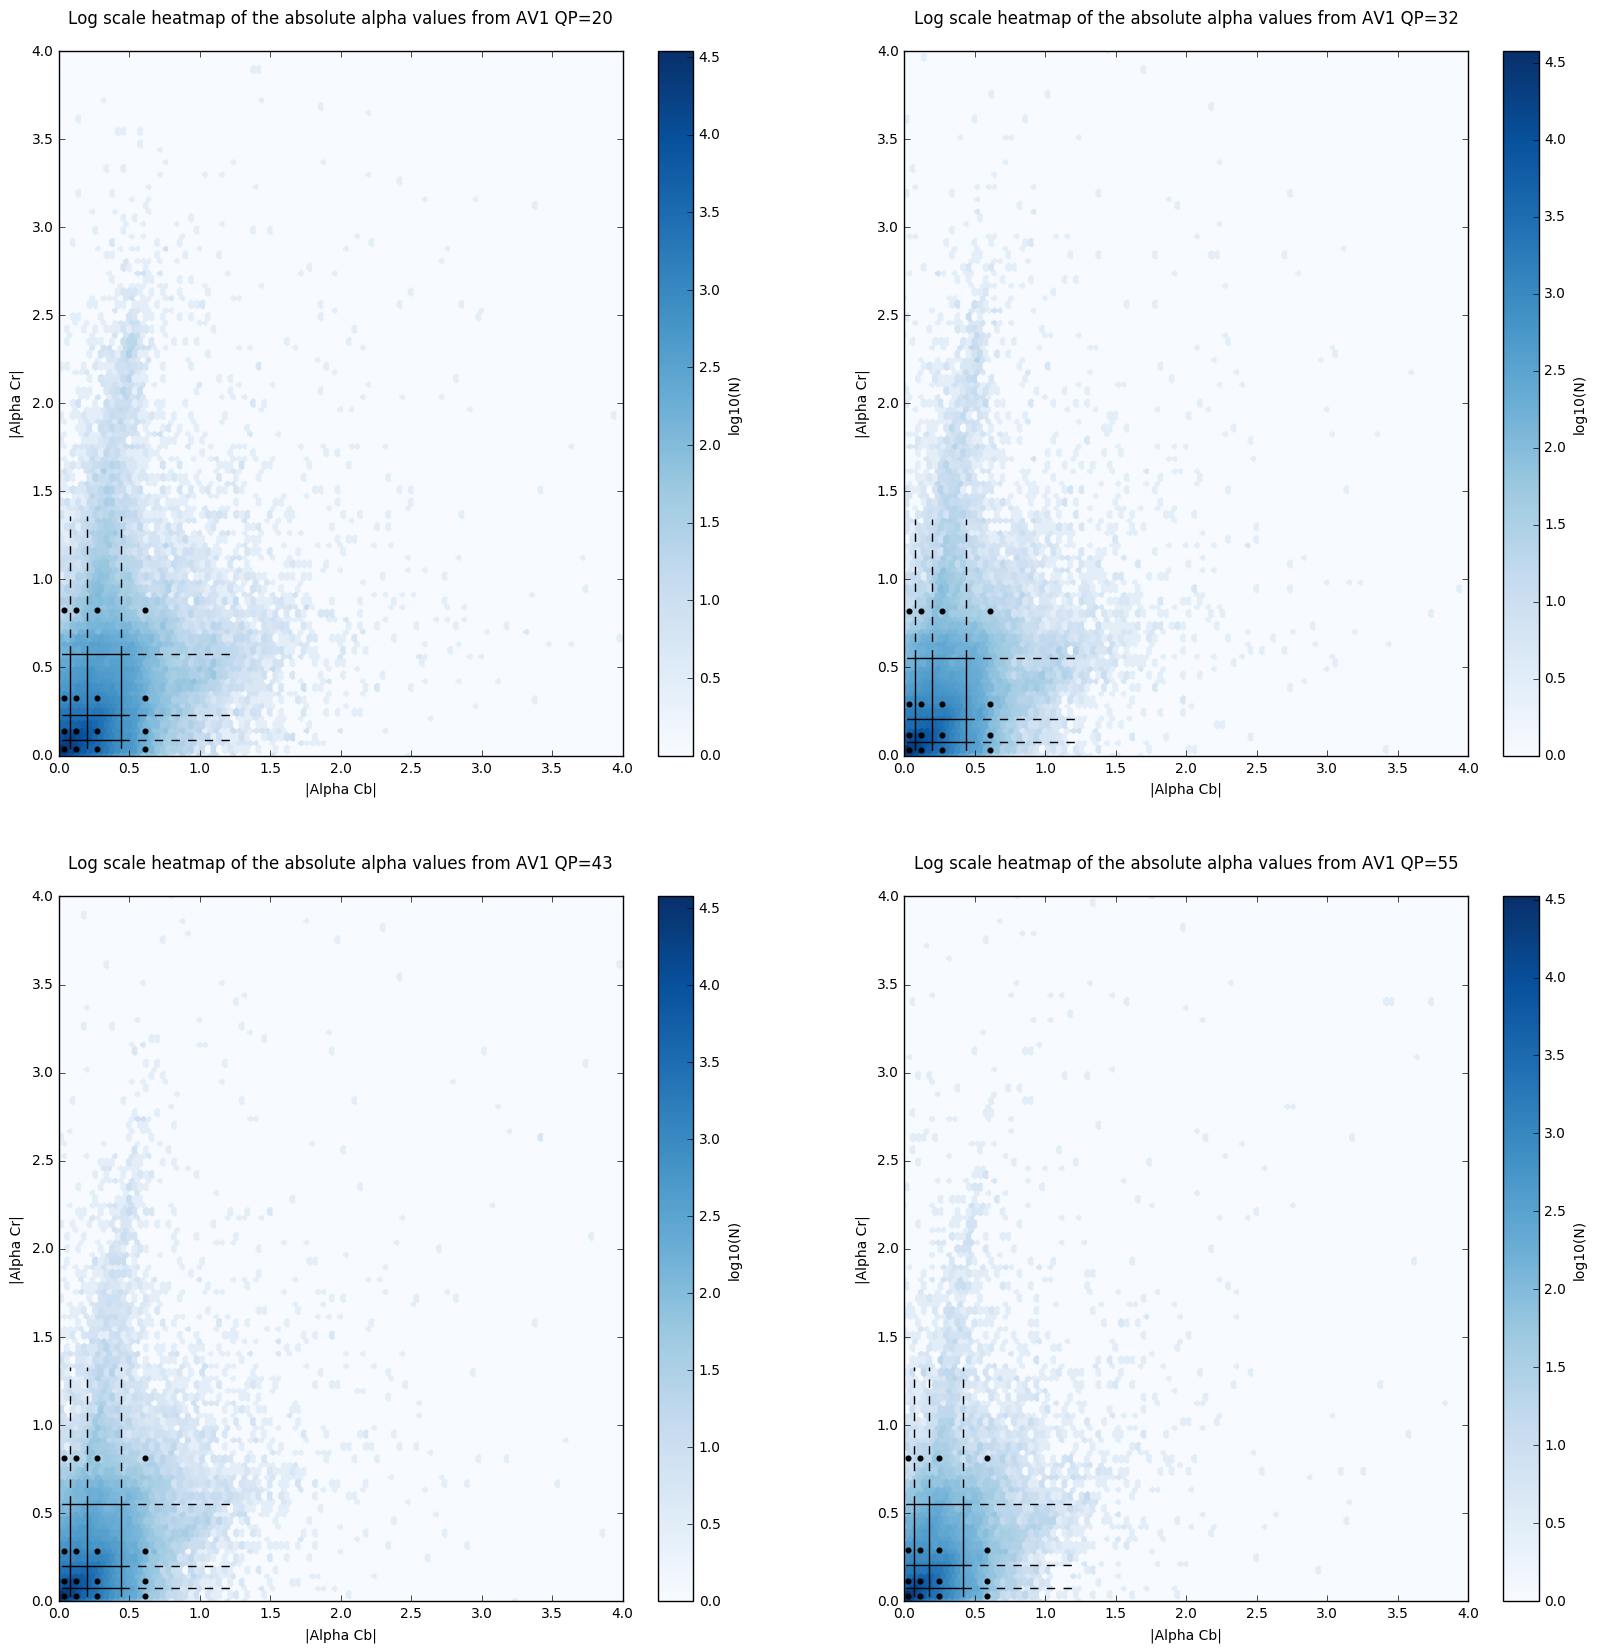

In [104]:
def abs_alpha_heatmap_voronoi(alphas, title):
    a_alphas_cb = np.abs(alphas[:,0])
    a_alphas_cr = np.abs(alphas[:,1])

    plt.hexbin(a_alphas_cb, a_alphas_cr, bins='log', cmap='Blues', extent=[0, 4, 0, 4])
    cb = plt.colorbar();
    cb.set_label('log10(N)')
    
    plt.xlabel("|Alpha Cb|")
    plt.ylabel("|Alpha Cr|")
    plt.title(title);
    
    centers_cb, label = kmeans(a_alphas_cb, 4)
    centers_cr, label = kmeans(a_alphas_cr, 4)
    centers = cartesian((np.sort(centers_cb), np.sort(centers_cr)))
    vor1D = Voronoi(centers)
    voronoi_plot_2d(vor1D, ax=plt.gca(), show_points=False, show_vertices=False)
    plt.scatter(centers[:,0], centers[:,1], c='black', marker='.', s=45);
    plt.gca().set_xlim([0, 4])
    plt.gca().set_ylim([0, 4]);
    
    return centers

plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
centers_20 = abs_alpha_heatmap_voronoi(alphas_20, "Log scale heatmap of the absolute alpha values from AV1 QP=20\n")
plt.subplot(2,2,2)
centers_32 = abs_alpha_heatmap_voronoi(alphas_32, "Log scale heatmap of the absolute alpha values from AV1 QP=32\n")
plt.subplot(2,2,3)
centers_43 = abs_alpha_heatmap_voronoi(alphas_43, "Log scale heatmap of the absolute alpha values from AV1 QP=43\n")
plt.subplot(2,2,4)
centers_55 = abs_alpha_heatmap_voronoi(alphas_55, "Log scale heatmap of the absolute alpha values from AV1 QP=55\n")

The 16 points obtained for each QP value appear to be quite similar. As shown in the following image, these points are not identical  

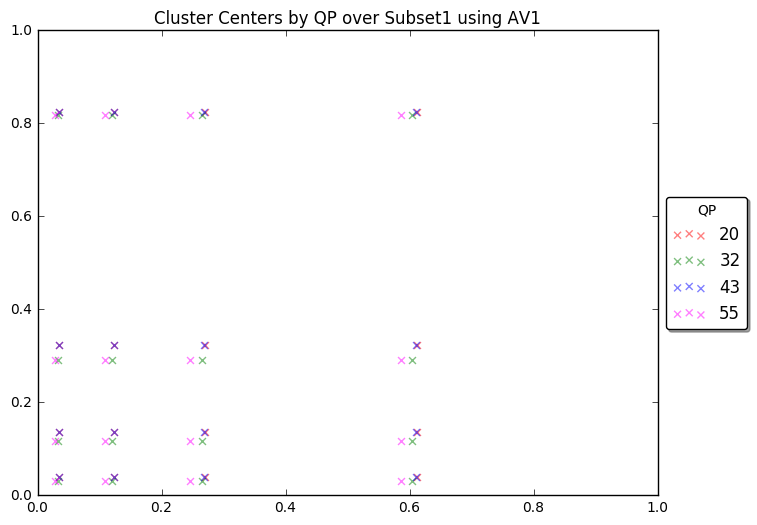

In [105]:
plt.figure(figsize=(8,6))
plt.scatter(centers_20[:,0], centers_20[:,1], c='red', alpha=0.5, marker='x', s=25, label="20");
plt.scatter(centers_32[:,0], centers_32[:,1], c='green', alpha=0.5, marker='x', s=25, label="32");
plt.scatter(centers_43[:,0], centers_20[:,1], c='blue', alpha=0.5, marker='x', s=25, label="43");
plt.scatter(centers_55[:,0], centers_32[:,1], c='magenta', alpha=0.5, marker='x', s=25, label="55");
plt.gca().set_xlim([0, 1])
plt.gca().set_ylim([0, 1]);

plt.legend(title="QP", loc='center left', bbox_to_anchor=(1, 0.5),
          fancybox=True, shadow=True, ncol=1)
plt.title("Cluster Centers by QP over Subset1 using AV1");

In order to evaluate the impact of the alphabet size used for $\bar{\alpha},$ we compute all the quantization tables with alphabets of sizes 3 to 16. These alphabets are then used for CfL and the resulting PSNR is measured over the entire [Kodak Lossless True Color Image Suite](http://r0k.us/graphics/kodak/index.html). We make the assumption here that this generalizes to AV1.

In [106]:
def cfl_prop_q(im, block_size, plane, codes):
    height, width, z = im.shape
    cfl = np.array(np.zeros((height, width)), dtype='uint8')
    
    num_codes = len(codes)
    for c in range(0, num_codes-1):
        table[c] = (codes[c] + codes[c+1]) / 2
    
    for y in range(0, height, block_size):
        for x in range(0, width, block_size):
            bY = im[y:y+block_size, x:x+block_size, 0]
            bC = im[y:y+block_size, x:x+block_size, plane]
            
            above_row = im[max(y-1,0), x:x+block_size, plane]
            left_col = im[y:y+block_size, max(x-1,0), plane]
            # DON'T ROUND!!! keep precision (look into doing this in AV1)
            DC_PRED = np.mean([above_row, left_col])
            
            L = bY - np.mean(bY)
            C = bC - DC_PRED
            
            sLL = np.sum(L*L)
            sLC = np.sum(L*C)
            
            if sLL != 0:
                alpha = sLC / sLL
            else:
                alpha = 0
            
            a_alpha = np.abs(alpha)
            
            i = 0
            while i < num_codes-1 and a_alpha > table[i]:
                i = i + 1
            alpha_q = codes[i]
            
            if alpha != a_alpha:
                alpha_q = -alpha_q
                
            cfl[y:y+block_size, x:x+block_size] = np.round(alpha_q * L + DC_PRED)
            
    return cfl

In [107]:
def compute_sse(cfl_block, chroma_block):
    return np.sum((cfl_block - chroma_block)**2)

def cfl_prop_q_sse(im, block_size, plane, codes):
    height, width, z = im.shape
    cfl = np.array(np.zeros((height, width)), dtype='uint8')
    
    num_codes = len(codes)
    
    for y in range(0, height, block_size):
        for x in range(0, width, block_size):
            bY = im[y:y+block_size, x:x+block_size, 0].astype(int)
            bC = im[y:y+block_size, x:x+block_size, plane].astype(int)
            
            above_row = im[max(y-1,0), x:x+block_size, plane].astype(int)
            left_col = im[y:y+block_size, max(x-1,0), plane].astype(int)
            # DON'T ROUND!!! keep precision
            DC_PRED = np.mean([above_row, left_col])
            
            L = bY - np.mean(bY)
            
            minSSE = 2560000
            ind = 0
            sign = 1
            for i in range(0, num_codes):
                sse = compute_sse(np.round(codes[i] * L + DC_PRED), bC)
                if sse < minSSE:
                    minSSE = sse
                    ind = i
                    sign = 1
                sse = compute_sse(np.round(-codes[i] * L + DC_PRED), bC)
                if sse < minSSE:
                    minSSE = sse
                    ind = i
                    sign = 0
                    
            if sign:
                alpha_q = codes[ind]
            else:
                alpha_q = -codes[ind]
                
            cfl[y:y+block_size, x:x+block_size] = np.round(alpha_q * L + DC_PRED)
            
    return cfl

In [108]:
class CfL():
    codes_cb = []
    codes_cr = []
    
    def compute_codes(self, k):
        starting_points = []
        for i in range(1,k+1):
            starting_points.append(np.round(i/(k+1)*100))
            
        starting_points = np.percentile(a_alphas_cb, q=starting_points)
        self.codes_cb, label = kmeans(a_alphas_cb, starting_points, check_finite=False)
        self.codes_cb = np.sort(self.codes_cb)
        self.codes_cr, label = kmeans(a_alphas_cr, self.codes_cb, check_finite=False)
        self.codes_cr = np.sort(self.codes_cr)
    
    def cfl_prop_q_sse_psnr(self, im):
        psnr_cb = psnr(im[:, :, 1], cfl_prop_q_sse(im, block_size, 1, self.codes_cb))
        psnr_cr = psnr(im[:, :, 2], cfl_prop_q_sse(im, block_size, 2, self.codes_cr))
        return psnr_cb, psnr_cr
    
    def cfl_prop_q_psnr(self, im):
        psnr_cb = psnr(im[:, :, 1], cfl_prop_q(im, block_size, 1, self.codes_cb))
        psnr_cr = psnr(im[:, :, 2], cfl_prop_q(im, block_size, 2, self.codes_cr))
        return psnr_cb, psnr_cr

In [109]:
k_psnrs_cb_q = np.zeros((17,24));
k_psnrs_cb_q_sse = np.zeros((17,24));
psnr_cb = np.zeros((24,1));
k_psnrs_cr_q = np.zeros((17,24));
k_psnrs_cr_q_sse = np.zeros((17,24));
psnr_cr = np.zeros((24,1));

a_alphas_cb = np.abs(np.concatenate((alphas_20[:,0], alphas_32[:,0], alphas_43[:,0], alphas_55[:,0])))
a_alphas_cr = np.abs(np.concatenate((alphas_20[:,1], alphas_32[:,1], alphas_43[:,1], alphas_55[:,1])))

_cfl = CfL()

with Pool() as pool:
    for k in log_progress(range(3,17)):
        _cfl.compute_codes(k)
        
        results_q = pool.map(_cfl.cfl_prop_q_psnr, kodims)
        results_q_sse = pool.map(_cfl.cfl_prop_q_sse_psnr, kodims)
        
        for i in range(0, num_kodim):
            psnr_cb, psnr_cr = results_q[i]
            k_psnrs_cb_q[k, i] = psnr_cb
            k_psnrs_cr_q[k, i] = psnr_cr
            psnr_cb, psnr_cr = results_q_sse[i]
            k_psnrs_cb_q_sse[k, i] = psnr_cb
            k_psnrs_cr_q_sse[k, i] = psnr_cr

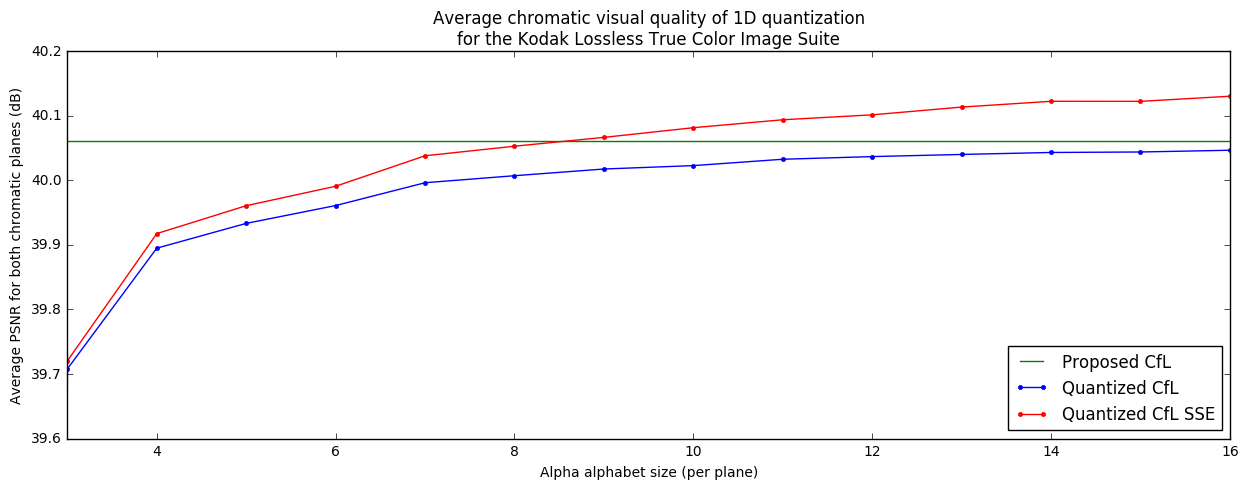

In [114]:
mean_k_psnrs_q = np.mean(np.column_stack((np.mean(k_psnrs_cb_q, axis=1), np.mean(k_psnrs_cr_q, axis=1))), axis=1)
mean_k_psnrs_q_sse = np.mean(np.column_stack((np.mean(k_psnrs_cb_q_sse, axis=1), np.mean(k_psnrs_cr_q_sse, axis=1))), axis=1)
mean_psnrs_cfl_prop = np.ones((17,1)) * np.mean((mean_psnr_cfl_prob_cb, mean_psnr_cfl_prob_cr)) 

plt.figure(figsize=(15,5))
plt.plot(np.arange(0,17), mean_psnrs_cfl_prop, 'g', label='Proposed CfL')
plt.plot(np.arange(0,17), mean_k_psnrs_q, 'b', marker='.', label='Quantized CfL')
plt.plot(np.arange(0,17), mean_k_psnrs_q_sse, 'r', marker='.', label='Quantized CfL SSE')
plt.gca().set_xlim([3, 16])
plt.gca().set_ylim([39.6, 40.2])
plt.xlabel('Alpha alphabet size (per plane)')
plt.ylabel('Average PSNR for both chromatic planes (dB)');
plt.title('Average chromatic visual quality of 1D quantization\nfor the Kodak Lossless True Color Image Suite')
plt.legend(loc='lower right');

It is important to notice that using only an alphabet of 3 $\bar{\alpha}\text{s}$, the cost of quantization is less than 0.5 dB. Furthermore, diminishing returns are observed past an alphabet of 8 $\bar{\alpha}\text{s}$.

As we will explain in the next section, an alphabet of 8 $\alpha$s per plane is particularly convenient, as once the sign bit is removed, both $\bar{\alpha}\text{s}$ can fit in one 4 bit symbol used by AV1's entropy coder.

### 2D Quantization
In this section, we investigate the impact on chromatic visual quality of using quantizing both chromatic $\bar{\alpha}\text{s}$ together, hence two-dimensional quantization.

The previous two alphabets of size 4 for $\bar{\alpha}$ Cb and $\bar{\alpha}$ Cr results in a combined alphabet of size 16. Instead, we use an alphabet of 16 to represent different combinations of $\bar{\alpha}$ for Cb and Cr.

For example, using $k=16$ with the first dimension being Cb and the second dimension being Cr, we get the following 16 points

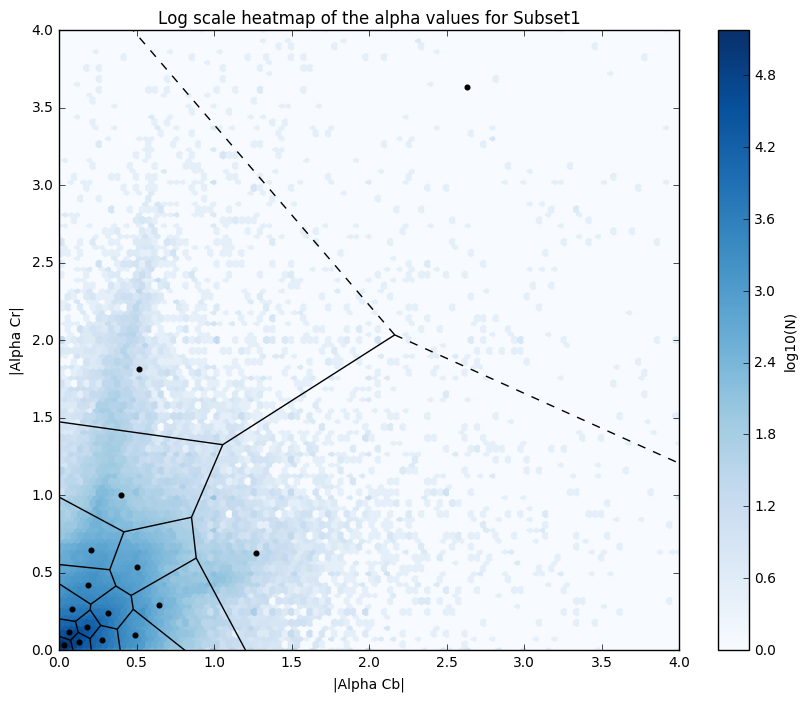

In [123]:
def compute2D_starting_points(k, alphas_cb, alphas_cr):
    starting_points = []
    for i in range(1,k+1):
        starting_points.append(np.round(i/(k+1)*100))
    starting_points = np.percentile(alphas_cb, q=starting_points)
    codes_cb, label = kmeans(alphas_cb, starting_points, check_finite=False)
    codes_cb = np.sort(codes_cb)
    codes_cr, label = kmeans(alphas_cr, codes_cb, check_finite=False)
    codes_cr = np.sort(codes_cr)
    return cartesian((codes_cb, codes_cr))

starting_points = compute2D_starting_points(4, a_alphas_cb, a_alphas_cr)

a_alphas_2D = np.column_stack((a_alphas_cb, a_alphas_cr))
centers_2D, label = kmeans(a_alphas_2D, starting_points, check_finite=False)
vor2D = Voronoi(centers_2D)

plt.figure(figsize=(10,8))

plt.hexbin(a_alphas_cb, a_alphas_cr, bins='log', cmap='Blues', extent=[0, 4, 0, 4])
plt.xlabel("|Alpha Cb|")
plt.ylabel("|Alpha Cr|")
plt.title("Log scale heatmap of the alpha values for Subset1")
cb = plt.colorbar();
cb.set_label('log10(N)')

voronoi_plot_2d(vor2D, ax=plt.gca(), show_points=False, show_vertices=False)
plt.gca().set_xlim([0, 4])
plt.gca().set_ylim([0, 4])
plt.scatter(centers_2D[:,0], centers_2D[:,1], c='black', marker='.', s=45);

In the following plot, we compare the average chromatic visual quality with respect to the combined alphabet size of both quantization scheme over the Kodak Lossless True Color Image Suite.

**TODO**: Add compute alpha using SSE

In [93]:
def cfl_prop_q2(im, block_size, codes):
    height, width, z = im.shape
    cfl_cb = np.array(np.zeros((height, width)), dtype='uint8')
    cfl_cr = np.array(np.zeros((height, width)), dtype='uint8')
    indices = []
    
    num_codes, z = codes.shape
    
    for y in range(0, height, block_size):
        for x in range(0, width, block_size):
            bY = im[y:y+block_size, x:x+block_size, 0]
            bCb = im[y:y+block_size, x:x+block_size, 1]
            bCr = im[y:y+block_size, x:x+block_size, 2]
            
            above_row_cb = im[max(y-1,0), x:x+block_size, 1]
            left_col_cb = im[y:y+block_size, max(x-1,0), 1]
            dc_pred_cb = np.mean([above_row_cb, left_col_cb])
            
            above_row_cr = im[max(y-1,0), x:x+block_size, 2]
            left_col_cr = im[y:y+block_size, max(x-1,0), 2]
            dc_pred_cr = np.mean([above_row_cr, left_col_cr])
            
            L = bY - np.mean(bY)
            Cb = bCb - dc_pred_cb
            Cr = bCr - dc_pred_cr
            
            sLL = np.sum(L*L)
            sLCb = np.sum(L*Cb)
            sLCr = np.sum(L*Cr)
            
            if sLL != 0:
                alpha_cb = sLCb / sLL
                alpha_cr = sLCr / sLL
            else:
                alpha_cb = 0
                alpha_cr = 0
                
            a_alpha_cb = abs(alpha_cb)
            a_alpha_cr = abs(alpha_cr)
            
            # Euclidian distance, we don't need to do sqrt because we want min
            smallest = (codes[0, 0] - a_alpha_cb)**2 + (codes[0, 1] - a_alpha_cr)**2
            ind = 0
            for c in range(1, num_codes):
                d = (codes[c,0] - a_alpha_cb)**2 + (codes[c,1] - a_alpha_cr)**2
                if d < smallest:
                    smallest = d
                    ind = c
            indices.append(ind)
            
            alpha_cb_q = codes[ind, 0]
            alpha_cr_q = codes[ind, 1]
            
            if alpha_cb != a_alpha_cb:
                alpha_cb_q = -alpha_cb_q
            
            if alpha_cr != a_alpha_cr:
                alpha_cr_q = -alpha_cr_q
            
            cfl_cb[y:y+block_size, x:x+block_size] = np.round(alpha_cb_q * L + dc_pred_cb)
            cfl_cr[y:y+block_size, x:x+block_size] = np.round(alpha_cr_q * L + dc_pred_cr)
            
    return cfl_cb, cfl_cr, indices

def cfl_prop_q2_psnr(im):
    cfl_cb, cfl_cr, indices = cfl_prop_q2(im, block_size, 1, (codes_cb, codes_cr))
    psnr_cb = psnr(im[:, :, 1], cfl_cb)
    psnr_cr = psnr(im[:, :, 2], cfl_cr
    return psnr_cb, psnr_cb

In [ ]:
class CfL2D():
    codes_cb = []
    codes_cr = []
    
    def compute2D_starting_points(k, alphas_cb, alphas_cr):
        starting_points = []
        for i in range(1,k+1):
            starting_points.append(np.round(i/(k+1)*100))
        starting_points = np.percentile(alphas_cb, q=starting_points)
        codes_cb, label = kmeans(alphas_cb, starting_points, check_finite=False)
        codes_cb = np.sort(codes_cb)
        codes_cr, label = kmeans(alphas_cr, codes_cb, check_finite=False)
        codes_cr = np.sort(codes_cr)
        return cartesian((codes_cb, codes_cr))
    
    def compute_codes():
        starting_points = compute2D_starting_points(k, a_alphas_cb, a_alphas_cr)
        codes_2d, labels = kmeans(a_alphas_2D, starting_points, check_finite=False)
        

In [122]:
k_psnrs_cb_q2 = np.zeros((17,24));
psnr_cb = np.zeros((24,1));
k_psnrs_cr_q2 = np.zeros((17,24));
psnr_cr = np.zeros((24,1));

k_range = np.arange(0,17)
k2_range = k_range**2

for k in log_progress(np.arange(3,17)):

    f = 0
    results_q2 = pool.map(cfl_prop_q2_psnr, kodims)
    
    for i in num_kodim:
        psnr_cb, psnr_cr = results_q2[i]
        k_psnrs_cb_q2[k, i] = psnr_cb
        k_psnrs_cr_q2[k, i] = psnr_cr

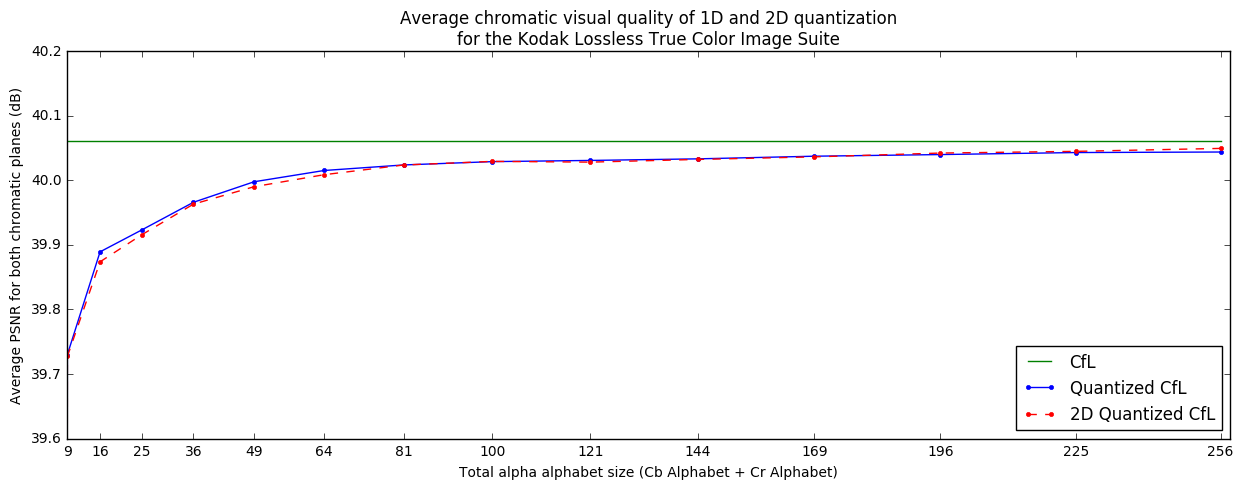

In [120]:
mean_k_psnrs_q2 = np.mean(np.column_stack((np.mean(k_psnrs_cb_q2, axis=1), np.mean(k_psnrs_cr_q2, axis=1))), axis=1)

plt.figure(figsize=(15,5))
plt.plot(k2_range, mean_psnrs_cfl_prop, 'g', label='CfL')
plt.plot(k2_range, mean_k_psnrs_q, 'b', marker='.', label='Quantized CfL')
plt.plot(k2_range, mean_k_psnrs_q2, 'r--', marker='.', label='2D Quantized CfL')
plt.gca().set_xticks(k2_range)
plt.gca().set_xlim([3**2, 16**2+2])
plt.gca().set_ylim([39.6, 40.2])
plt.xlabel('Total alpha alphabet size (Cb Alphabet + Cr Alphabet)')
plt.ylabel('Average PSNR for both chromatic planes (dB)');
plt.title('Average chromatic visual quality of 1D and 2D quantization\nfor the Kodak Lossless True Color Image Suite')
plt.legend(loc='lower right');

Interestingly, it currently appears the 2D quantization does not yield significant benefits

## Signaling

The proposed signaling scheme is based on the previous findings that the benefits of an alphabet size greater than 8 $\bar{\alpha}\text{s}$ are relatively small and that the entropy coding tools in AV1 support cumulative distribution functions of up to 16 symbols. We propose to signal $\bar{\alpha}$ at the block level and combine the $\bar{\alpha}$ for Cb and the $\bar{\alpha}$ for Cr into the same symbol.

Combining $\bar{\alpha}$ Cb and $\bar{\alpha}$ Cr in the same symbol exploits the fact that some combinations of $\bar{\alpha}$ Cb and $\bar{\alpha}$ Cr are highly improbable. In order to increase the $\bar{\alpha}$ alphabet without using another symbol, we code a seperate sign bit for $\bar{\alpha}$ Cb and $\bar{\alpha}$ Cr. By adding "0" to the alphabet, we can avoid signaling the sign bit when "0" is chosen. However, doing so reduces the number of codes from 8 to 7.

### TODO
  * Show signaling at the block level vs signaling at the transform level
  * Show the joint probabilities of alpha Cb and alpha Cr
  * Make probability table
  * Add skip special case
  * Is it worth it to use seperate codes and tables for Cb and Cr?


### Building the cumulative distribution function (CDF)

In this section, we focus on building the commulative distribution function (CDF) used to encode the index of the combined $\bar{\alpha}\text{s}$ for Cb and Cr.

To do so, we start with a uniform distribution and measure the occurence of each symbol in the bitstream resulting from encoding Subset1.

In [ ]:
def load_alphas_q(qp):
    alphas = []
    with tarfile.open(os.path.join('data', 'alphas_prob', "alphas_prob_%d.tar.gz" % qp)) as tf:
        for entry in tf:
            if entry.isfile():
                alphas = np.concatenate((alphas, np.genfromtxt(tf.extractfile(entry))), axis=0)
    return alphas

def compute_prob(alphas):
    prob = np.zeros((16,1))
    for a in alphas.astype(int):
        prob[a] = prob[a] + 1
    return prob / sum(prob)

alphas_q_20_prob = compute_prob(load_alphas_q(20))
alphas_q_32_prob = compute_prob(load_alphas_q(32))
alphas_q_43_prob = compute_prob(load_alphas_q(43))
alphas_q_55_prob = compute_prob(load_alphas_q(55))
alphas_q_63_prob = compute_prob(load_alphas_q(63))

In [ ]:
plt.figure(figsize=(15,5))
plt.bar(np.arange(16)-0.2, alphas_q_20_prob * 100, width=0.1, align='center', color='b', label='20')
plt.bar(np.arange(16)-0.1, alphas_q_32_prob * 100, width=0.1, align='center', color='g', label='32')
plt.bar(np.arange(16),     alphas_q_43_prob * 100, width=0.1, align='center', color='r', label='43')
plt.bar(np.arange(16)+0.1, alphas_q_55_prob * 100, width=0.1, align='center', color='c', label='55')
plt.bar(np.arange(16)+0.2, alphas_q_63_prob * 100, width=0.1, align='center', color='m', label='63')
plt.legend(title="QP");

In [ ]:
all_probs = np.column_stack((alphas_q_20_prob, alphas_q_32_prob, alphas_q_43_prob, alphas_q_55_prob, alphas_q_63_prob))
all_probs_mean = np.mean(all_probs, axis=1)
all_probs_cdf = np.cumsum(all_probs_mean)
all_probs_cdf_16 = np.round(all_probs_cdf * 32768)

print(all_probs_cdf_16)

## Results

### Proposed quantization table for 16 symbols
Based on these results, we recommend using the following table in AV1

#### 1D Quantization table

In [189]:
codes_1d = compute2D_starting_points(4, a_alphas_cb, a_alphas_cr)
codes_1d[0,0] = 0
codes_1d[0,1] = 0
codes_1d[1,0] = 0
codes_1d[2,0] = 0
codes_1d[3,0] = 0
codes_1d[0,0] = 0
codes_1d[4,1] = 0
codes_1d[8,1] = 0
codes_1d[12,1] = 0
print(codes_1d)

[[ 0.          0.        ]
 [ 0.          0.1298463 ]
 [ 0.          0.32787086]
 [ 0.          0.87551493]
 [ 0.11864264  0.        ]
 [ 0.11864264  0.1298463 ]
 [ 0.11864264  0.32787086]
 [ 0.11864264  0.87551493]
 [ 0.27456574  0.        ]
 [ 0.27456574  0.1298463 ]
 [ 0.27456574  0.32787086]
 [ 0.27456574  0.87551493]
 [ 0.67408152  0.        ]
 [ 0.67408152  0.1298463 ]
 [ 0.67408152  0.32787086]
 [ 0.67408152  0.87551493]]


#### 1D Probability table

In [190]:
def compute_probabilities(alphas, codes):
    prob = np.zeros((16,1))
    for a in alphas:
        min_dist =(a[0] - codes[0,0])**2 + (a[1] - codes[0,1])**2
        ind = 0
        for i in range(1,16):
            dist = (a[0] - codes[i,0])**2 + (a[1] - codes[i,1])**2
            if dist < min_dist:
                min_dist = dist
                ind = i
        prob[ind] = prob[ind] + 1
    return prob

def compute_cdf(prob):
    sumprob = sum(prob)
    prob[0] = prob[0] / sumprob
    for i in range(1,16):
        prob[i] = prob[i-1] + prob[i] / sumprob
    return np.round(prob * 32768)

prob = compute_probabilities(a_alphas_2D, codes_1d)
cdf = compute_cdf(prob)
print(cdf)

[[  6787.]
 [  9540.]
 [ 10011.]
 [ 10063.]
 [ 14790.]
 [ 21734.]
 [ 23092.]
 [ 23270.]
 [ 24669.]
 [ 28281.]
 [ 30458.]
 [ 31029.]
 [ 31179.]
 [ 31563.]
 [ 32321.]
 [ 32768.]]


#### 1D Quantization results in AV1

Results on Subset1

|   PSNR |  PSNR Cb |  PSNR Cr | PSNR HVS |   SSIM | MS SSIM | CIEDE 2000 |
|   ---: |     ---: |     ---: |     ---: |   ---: |    ---: |       ---: |
| 1.2402 | -14.6546 | -12.4855 |   1.4059 | 1.2869 |  1.2782 |    -4.0100 |

https://arewecompressedyet.com/?job=master%402017-03-27T18%3A41%3A56.236Z&job=CfL_1DQuant_Cheating%402017-04-12T19%3A21%3A35.757Z

#### 2D Quantization table

In [203]:
codes_2d, labels = kmeans(a_alphas_2D, codes_1d, check_finite=False)
codes_2d[0,0] = 0
codes_2d[0,1] = 0
#codes_2d[1,0] = 0
codes_2d[4,1] = 0
print(codes_2d)

[[ 0.          0.        ]
 [ 0.06234922  0.11337426]
 [ 0.08943925  0.26751303]
 [ 0.2521174   0.85320979]
 [ 0.12720606  0.        ]
 [ 0.17451384  0.13839724]
 [ 0.17929698  0.48593537]
 [ 0.60767755  0.732516  ]
 [ 0.27741244  0.06705721]
 [ 0.28615983  0.2377901 ]
 [ 0.44578057  0.42282997]
 [ 0.49694771  1.73292546]
 [ 0.80801539  0.29155805]
 [ 0.47680614  0.13408329]
 [ 1.46773033  0.70560485]
 [ 2.68210365  3.89024457]]


#### 2D Probability table

In [202]:
prob = compute_probabilities(a_alphas_2D, codes_2d)
cdf = compute_cdf(prob)
print(cdf)

[[  6509.]
 [ 13553.]
 [ 15291.]
 [ 15740.]
 [ 19828.]
 [ 24084.]
 [ 25250.]
 [ 25646.]
 [ 28028.]
 [ 30111.]
 [ 31050.]
 [ 31211.]
 [ 31562.]
 [ 32638.]
 [ 32755.]
 [ 32768.]]


#### 2D Quantization results in AV1

Results on Subset1

|   PSNR |  PSNR Cb |  PSNR Cr | PSNR HVS |   SSIM | MS SSIM | CIEDE 2000 |
|   ---: |     ---: |     ---: |     ---: |   ---: |    ---: |       ---: |
| 1.2742 | -15.2687 | -13.4287 |   1.4854 | 1.3268 |  1.3296 |    -4.2861 |

https://arewecompressedyet.com/?job=master%402017-03-27T18%3A41%3A56.236Z&job=CfL_2DQuant_Cheating%402017-04-12T20%3A03%3A18.779Z

### Current best results for Subset1 (using Barrbrain's rotation and distorsion function):

|   PSNR |  PSNR Cb |  PSNR Cr | PSNR HVS |   SSIM | MS SSIM | CIEDE 2000 |
|   ---: |     ---: |     ---: |     ---: |   ---: |    ---: |       ---: |
| 1.5489 | -16.3162 | -14.3221 |   1.7149 | 1.6028 |  1.5752 |    -4.5870 |

https://arewecompressedyet.com/?job=master%402017-03-27T18%3A41%3A56.236Z&job=CfL_barrbrain_rot_dist%402017-04-13T12%3A38%3A12.765Z

## References
[1] Steinar Midtskogen,"Improved chroma prediction" IETF draft-midtskogen-netvc-chromapred-02 https://tools.ietf.org/html/draft-midtskogen-netvc-chromapred-02 (October 2016)

[2] Nathan E. Egge and Jean-Marc Valin, "Predicting Chroma from Luma with Frequency Domain Intra Prediction", https://people.xiph.org/~unlord/spie_cfl.pdf (April 2016)